In [1]:
import pickle

random = False
mv = False
ivr = True

if random:
    timeloss_emukit_model = pickle.load(open('../experimental_design/models/250_random_points_supervised_GP_timeloss.pkl', "rb"))
    emissions_emukit_model = pickle.load(open('../experimental_design/models/270_random_points_supervised_GP_co2.pkl', "rb"))
elif mv:
    timeloss_emukit_model = pickle.load(open('../experimental_design/models/model_variance_20_init_points_250_loops_timeloss.pkl', "rb"))
    emissions_emukit_model = pickle.load(open('../experimental_design/models/model_variance_20_init_points_250_loops_co2.pkl', "rb"))
elif ivr:
    timeloss_emukit_model = pickle.load(open('../experimental_design/models/integrated_variance_reduction_20_init_points_250_loops_timeloss.pkl', "rb"))
    emissions_emukit_model = pickle.load(open('../experimental_design/models/integrated_variance_reduction_20_init_points_250_loops_co2.pkl', "rb"))

In [2]:
from experimental_design.config import get_ofat_parameter_spaces
parameter_spaces = get_ofat_parameter_spaces()

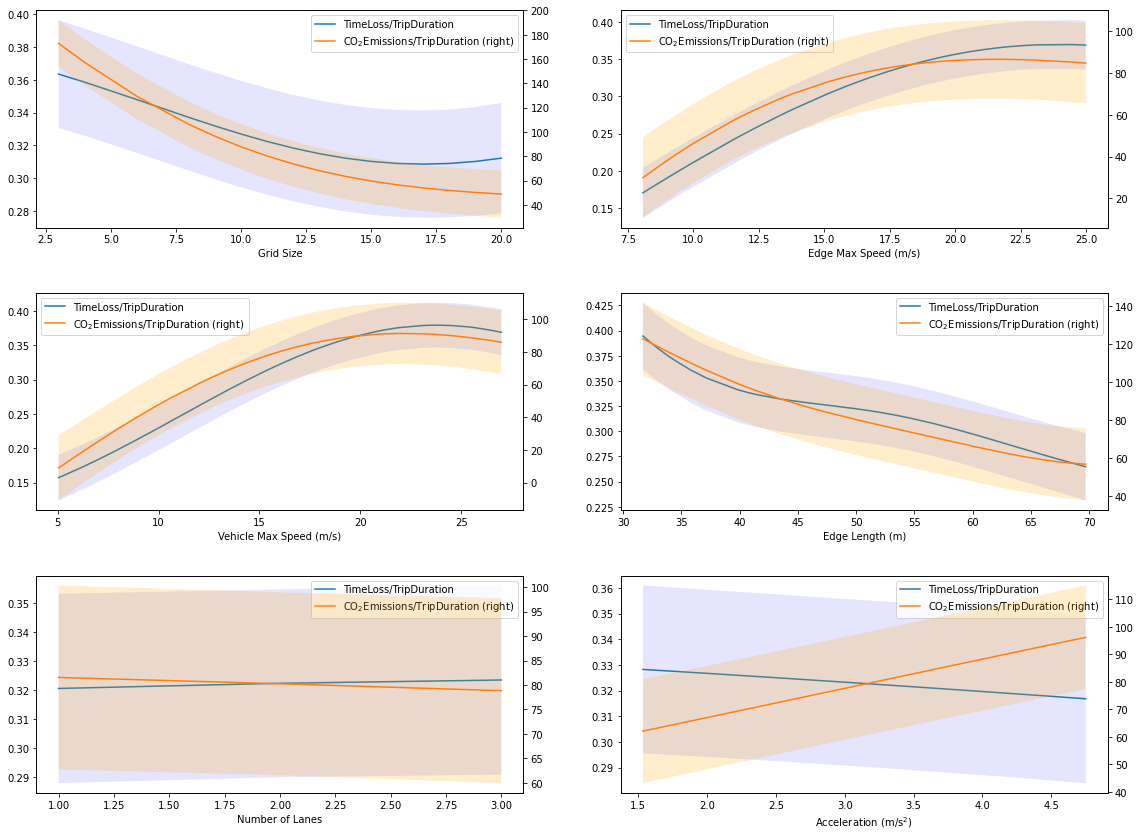

In [3]:
from emukit.core.initial_designs import RandomDesign
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

num_data_points = 50
fig, axs = plt.subplots(len(parameter_spaces)//2, 2, figsize=[6.4*(len(parameter_spaces)//2), 4.8 * 3])
for idx, space_dict in enumerate(parameter_spaces):
    parameter_name = space_dict['name']
    parameter_space = space_dict['space']
    design = RandomDesign(parameter_space)  # initialize with random points
    test_X = design.get_samples(num_data_points)
    emissions_pred_Y, emissions_pred_Y_variance = emissions_emukit_model.predict(test_X)
    timeloss_pred_Y, timeloss_pred_Y_variance = timeloss_emukit_model.predict(test_X)

    emissions_X = test_X[:, idx]
    emissions_Y = emissions_pred_Y[:, 0]
    emissions_Variance = emissions_pred_Y_variance[:, 0]
    emissions_sort_positions = emissions_X.argsort()
    emissions_X = emissions_X[emissions_sort_positions]
    emissions_Y = emissions_Y[emissions_sort_positions]
    emissions_Std = np.sqrt(emissions_Variance[emissions_sort_positions])

    timeloss_X = test_X[:, idx]
    timeloss_Y = timeloss_pred_Y[:, 0]
    timeloss_Variance = timeloss_pred_Y_variance[:, 0]
    timeloss_sort_positions = timeloss_X.argsort()
    timeloss_X = timeloss_X[timeloss_sort_positions]
    timeloss_Y = timeloss_Y[timeloss_sort_positions]
    timeloss_Std = np.sqrt(timeloss_Variance[timeloss_sort_positions])

    data = {
        'timeloss_X': timeloss_X, 'TimeLoss/TripDuration': timeloss_Y, 'timeloss_Std': timeloss_Std,
        'emissions_X': emissions_X, 'CO$_2$Emissions/TripDuration': emissions_Y, 'emissions_Std': emissions_Std,
    }
    ax = axs[idx//2][idx%2]
    _ax1 = pd.DataFrame(data).plot.line(x='timeloss_X', y='TimeLoss/TripDuration', ax=ax) #, yerr='timeloss_Std')
    _ax2 = pd.DataFrame(data).plot.line(secondary_y=True, x='emissions_X', y='CO$_2$Emissions/TripDuration', ax=ax) #, yerr='emission_Std')
    _ax1.fill_between(timeloss_X, data['TimeLoss/TripDuration'] - data['timeloss_Std'], data['TimeLoss/TripDuration'] + data['timeloss_Std'],
                 facecolor='blue', alpha=0.1, interpolate=True)
    _ax2.fill_between(emissions_X, data['CO$_2$Emissions/TripDuration'] - data['emissions_Std'], data['CO$_2$Emissions/TripDuration'] + data['emissions_Std'],
                 facecolor='orange', alpha=0.2, interpolate=True)
    ax.set_xlabel(parameter_name)
plt.subplots_adjust(hspace=0.3)
fig.show()